# Анализ данных тарифов оператора связи для рекомендаций клиентам, пользующихся архивными тарифами.

## План работ:
- 1 Ознакомление с данными.
- 2 Разбиение данных на выборки.
- 3 Исследование моделей.
- 4 Проверка модели на тестовой выборке.
- 5 Проверка модели на адекватность.
- 6 Общий вывод.

## Описание данных.  
- сalls — количество звонков,
- minutes — суммарная длительность звонков в минутах,
- messages — количество sms-сообщений,
- mb_used — израсходованный интернет-трафик в Мб,
- is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

## 1. Откройте и изучите файл

In [1]:
import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.tree import DecisionTreeClassifier as dtc
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.linear_model import LogisticRegression as lr

from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score as acs
from sklearn.metrics import classification_report
from sklearn.dummy import DummyClassifier

Откроем и рассмотрим файл с данными:

In [2]:
tarifs = pd.read_csv('datasets/users_behavior.csv')

In [3]:
tarifs.head(12)

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0


In [4]:
list_tarifs = ['calls', 'minutes', 'messages', 'mb_used']

In [5]:
tarifs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


Данные были предобработаны. Посмотрим на распределения и боксплоты:

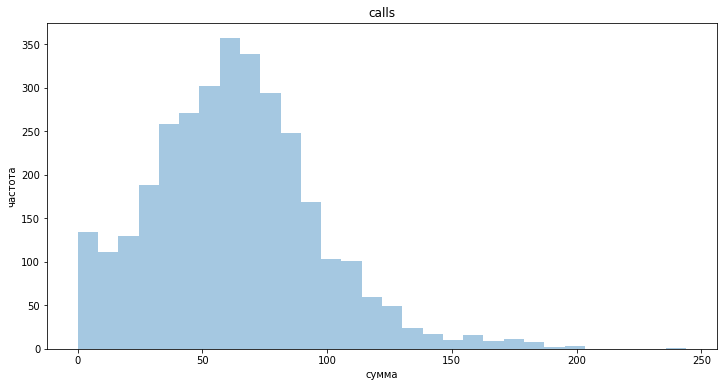

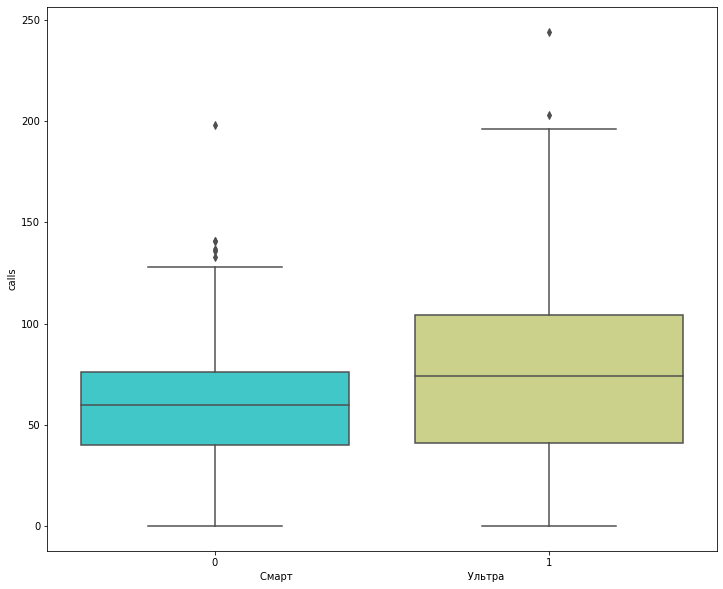

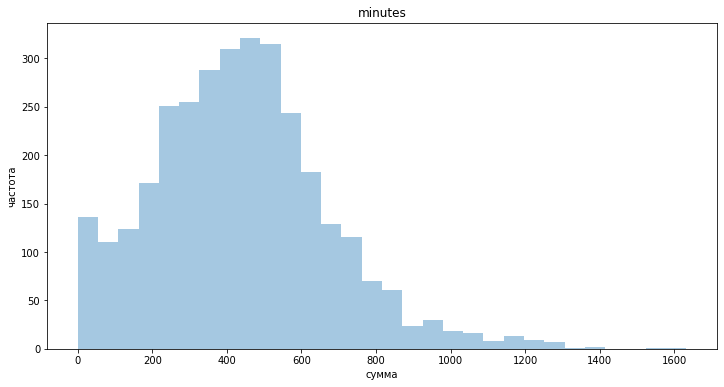

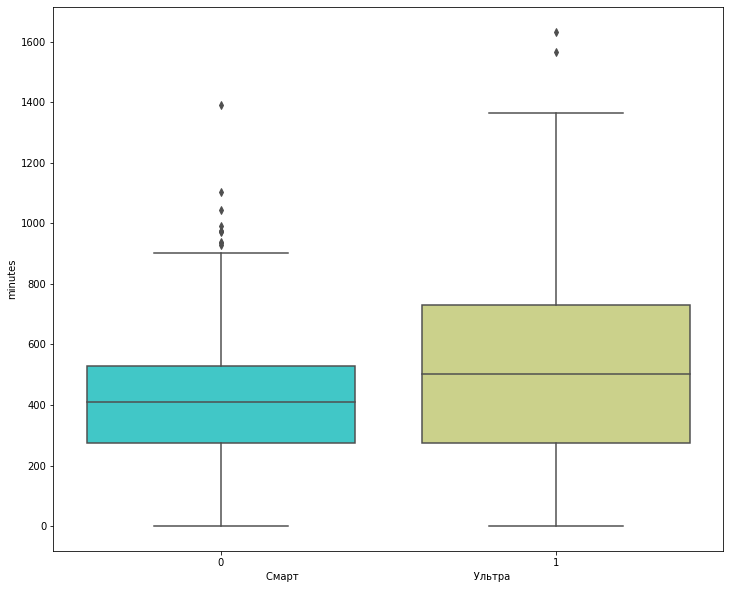

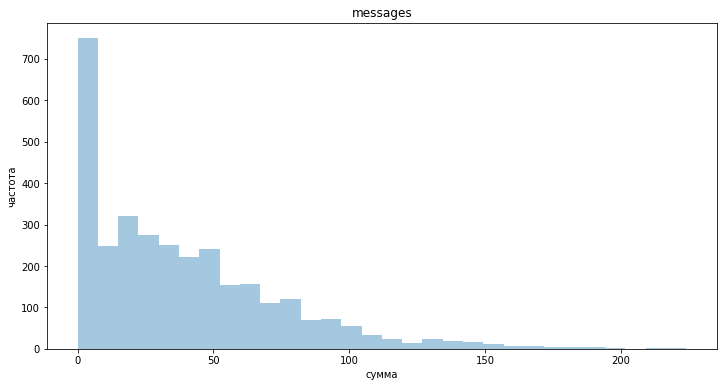

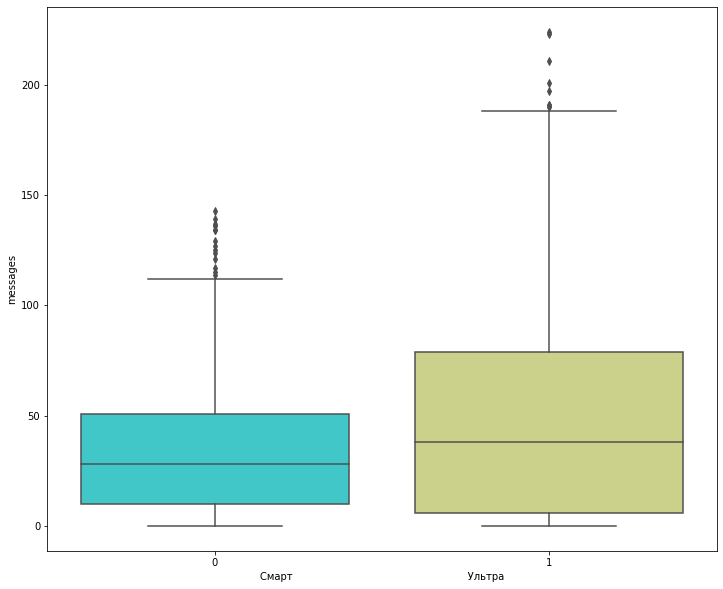

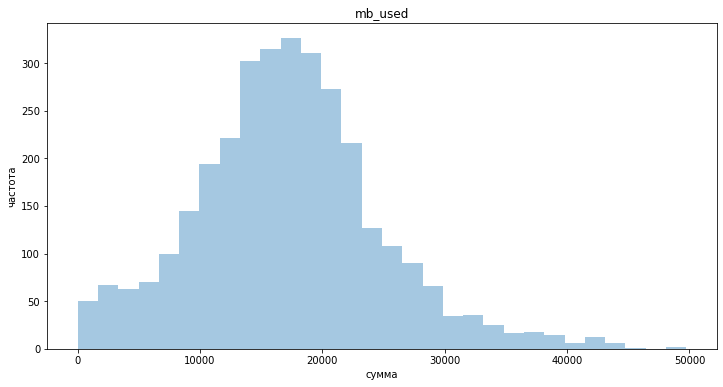

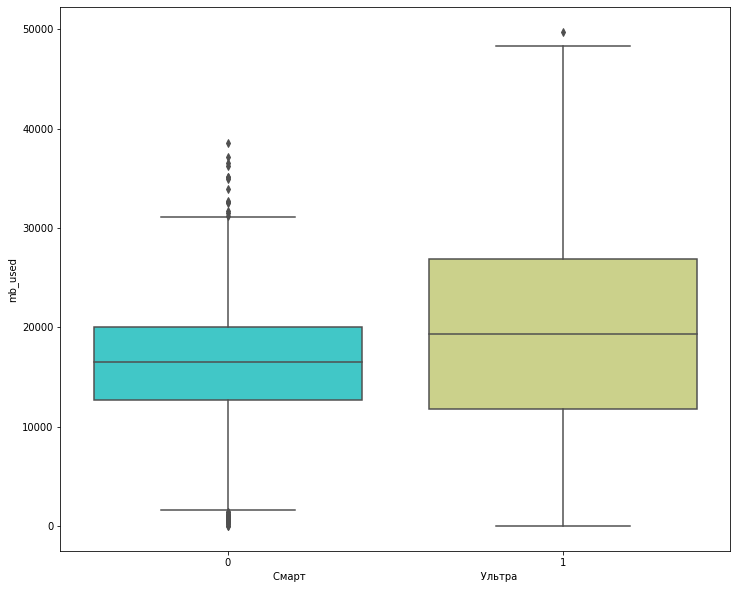

In [6]:
for i in list_tarifs:
    plt.figure(figsize=(12, 6))
    sns.distplot(tarifs[i], kde=False, bins=30)
    plt.title(i)
    plt.xlabel('сумма')
    plt.ylabel('частота')
    plt.show()
    plt.figure(figsize=(12, 10))
    sns.boxplot(x=tarifs['is_ultra'], y=tarifs[i], palette='rainbow')
    plt.xlabel('Смарт                                                        Ультра')
    plt.ylabel(i)
    plt.show()

Посмотрим на раздельное распределение столбцов по тарифам Смарт и Ультра:

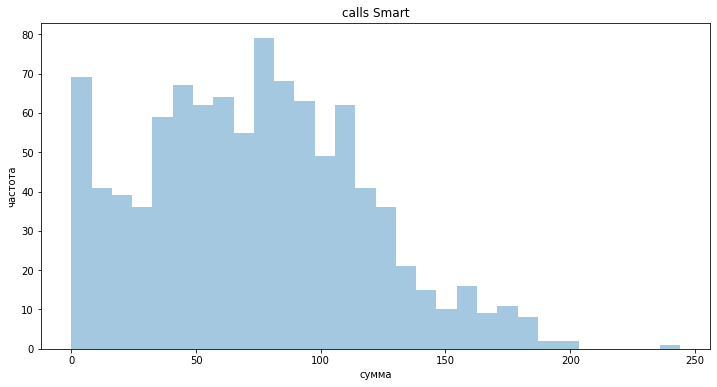

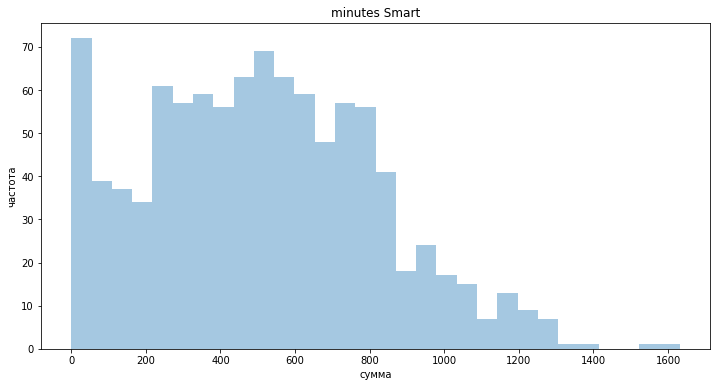

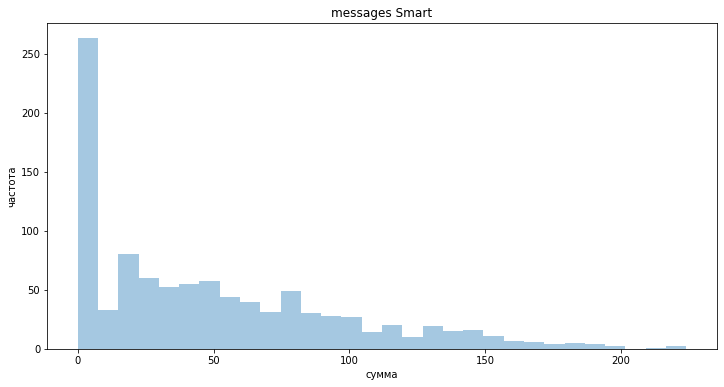

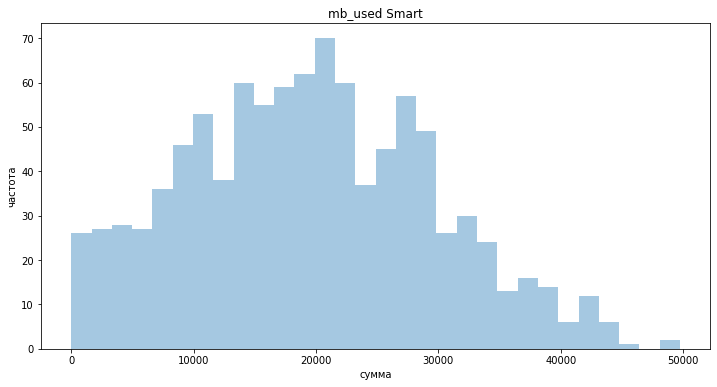

In [7]:
for i in list_tarifs:
    tarifs_grouped_ult = tarifs.query('is_ultra == 1')
    plt.figure(figsize=(12, 6))
    sns.distplot(tarifs_grouped_ult[i], kde=False, bins=30)
    plt.title(i + ' Smart')
    plt.xlabel('сумма')
    plt.ylabel('частота')
    plt.show()

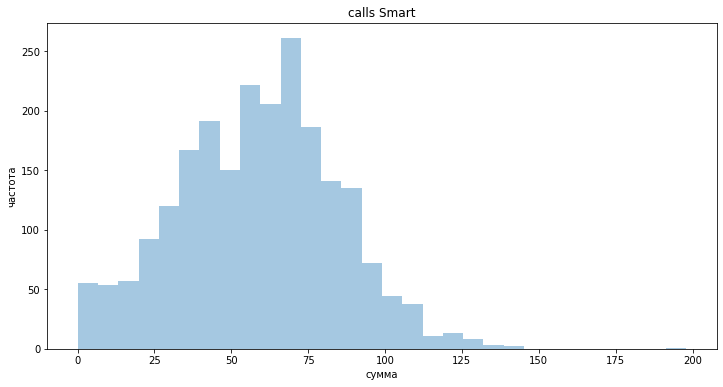

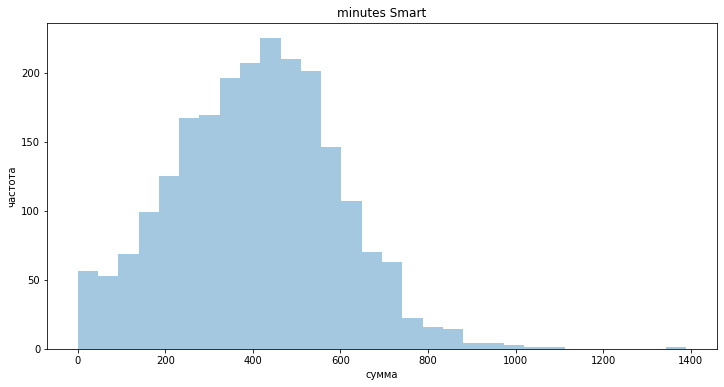

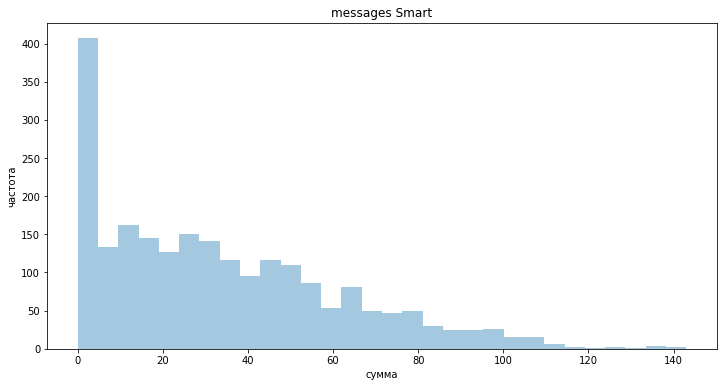

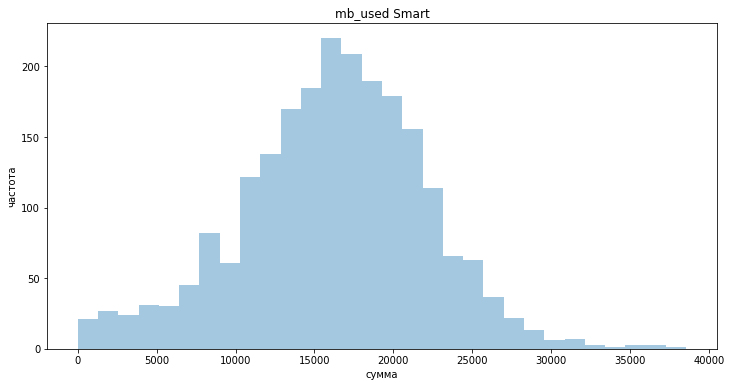

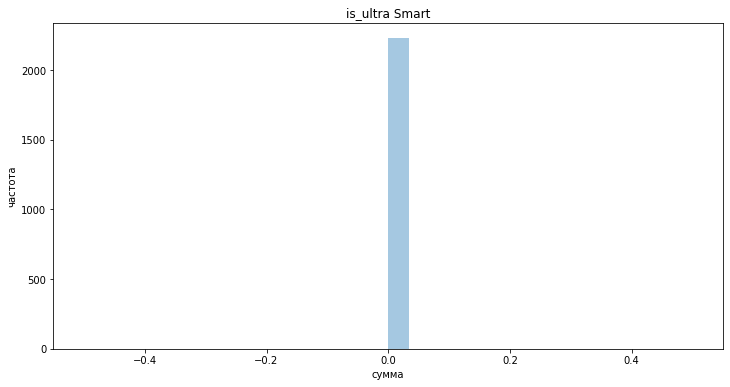

In [8]:
for i in tarifs:
    tarifs_grouped_ult = tarifs.query('is_ultra == 0')
    plt.figure(figsize=(12, 6))
    sns.distplot(tarifs_grouped_ult[i], kde=False, bins=30)
    plt.title(i + ' Smart')
    plt.xlabel('сумма')
    plt.ylabel('частота')
    plt.show()

Посмотрим на зависимости столбцов друг от друга:

In [9]:
for i in tarifs:
    for j in tarifs:
        if j != i:
            print(f'{i} коррелирует с {j} = {tarifs[i].corr(tarifs[j])}')

calls коррелирует с minutes = 0.9820832355742288
calls коррелирует с messages = 0.17738450121769558
calls коррелирует с mb_used = 0.28644151203505447
calls коррелирует с is_ultra = 0.20712155898607576
minutes коррелирует с calls = 0.9820832355742288
minutes коррелирует с messages = 0.17311022580969082
minutes коррелирует с mb_used = 0.28096693508821463
minutes коррелирует с is_ultra = 0.2069546381216952
messages коррелирует с calls = 0.17738450121769553
messages коррелирует с minutes = 0.1731102258096908
messages коррелирует с mb_used = 0.19572112095582156
messages коррелирует с is_ultra = 0.2038298385355364
mb_used коррелирует с calls = 0.2864415120350544
mb_used коррелирует с minutes = 0.28096693508821463
mb_used коррелирует с messages = 0.19572112095582156
mb_used коррелирует с is_ultra = 0.19856764561974263
is_ultra коррелирует с calls = 0.20712155898607565
is_ultra коррелирует с minutes = 0.20695463812169515
is_ultra коррелирует с messages = 0.20382983853553638
is_ultra коррелируе

Некоторые столбцы имеют очень большую корреляцию друг с другом. Посмотрим на них:

In [10]:
for i in tarifs:
    for j in tarifs:
        correl = tarifs[i].corr(tarifs[j])
        if correl > 0.9 and j != i:
            print(f'Можно удалить из данных один из столбцов {i} или {j}')

Можно удалить из данных один из столбцов calls или minutes
Можно удалить из данных один из столбцов minutes или calls


Удалим столбцец calls, т.к. он почти не повлияет на обучение и работу моделей:

In [11]:
tarifs = tarifs.drop(['calls'], axis=1)

In [12]:
tarifs.shape

(3214, 4)

## 2. Разбейте данные на выборки

Разобъём выборку на признаки и целевой признак:

In [13]:
features = tarifs.drop(['is_ultra'], axis=1)
target = tarifs['is_ultra']

Проверим количество и процентное соотношение в целей выборке:

In [14]:
target.value_counts()

0    2229
1     985
Name: is_ultra, dtype: int64

In [15]:
target.value_counts() / target.shape[0]

0    0.693528
1    0.306472
Name: is_ultra, dtype: float64

Примерно 70% Смарт и 30% Ультра.  
Разобъём всю выборку на валидационную + тестовую(20 % от всей) и тренировочную(80%):

In [16]:
features_train, features_valid_test, target_train, target_valid_test = tts(features, target,
                                                                           test_size=0.2, random_state=12345,
                                                                           stratify=target)

Разобъём валидационную + тестовую выборку на валидационную и тестовую(по 50%, что составит по 10% от всей выборки):

In [17]:
features_valid, features_test, target_valid, target_test = tts(features_valid_test, target_valid_test,
                                                               test_size=0.5, random_state=12345,
                                                               stratify=target_valid_test)

Проверим количество и процентное соотношение:  
Тренировочная выборка:

In [18]:
target_train.value_counts()

0    1783
1     788
Name: is_ultra, dtype: int64

In [19]:
target_train.value_counts() / target_train.shape[0]

0    0.693504
1    0.306496
Name: is_ultra, dtype: float64

Валидационная выборка:

In [20]:
target_valid.value_counts()

0    223
1     98
Name: is_ultra, dtype: int64

In [21]:
target_valid.value_counts() / target_valid.shape[0]

0    0.694704
1    0.305296
Name: is_ultra, dtype: float64

И тестовая выборка:

In [22]:
target_test.value_counts()

0    223
1     99
Name: is_ultra, dtype: int64

In [23]:
target_test.value_counts() / target_test.shape[0]

0    0.692547
1    0.307453
Name: is_ultra, dtype: float64

In [24]:
features_train.shape, features_valid.shape, features_test.shape

((2571, 3), (321, 3), (322, 3))

Количество и процентное соотношение во всех целевых признаках равномерное.

## 3. Исследуйте модели

Создадим и проверим модели DecisionTreeClassifierб RandomForestClassifier и LogisticRegression.  Начнём с DecisionTreeClassifier:

In [25]:
dict_md_dtc = {}
list_dtc = []
for i in range(1, 11):
    model_dtc = dtc(max_depth=i, random_state=12345)
    model_dtc.fit(features_train, target_train)
    predictions_valid_dtc = model_dtc.predict(features_valid)
    acs_dtc = acs(predictions_valid_dtc, target_valid)
    dict_md_dtc[i] = acs_dtc
    list_dtc.append(acs_dtc)
    #print(f'Предсказания валидационные при глубине дерева {i}: {acs_dtc}')
dict_md_dtc_max = {}
max_dtc = max(list_dtc)
for key, values in dict_md_dtc.items():
    if max_dtc == values:
        dict_md_dtc_max['DecisionTreeClassifier max_depth = ' + str(key)] = values
print(f'Глубина дерева с максимальным значеним акураси DecisionTreeClassifier:\n{dict_md_dtc_max}')

Глубина дерева с максимальным значеним акураси DecisionTreeClassifier:
{'DecisionTreeClassifier max_depth = 6': 0.8068535825545171}


Наивысшее акураси у DecisionTreeClassifier получилось при глубине дерева в 6.  

Рассмотрим RandomForestClassifier(случайный лес):

In [26]:
dict_n_e_rfc = {}
list_rfc = []
for i in range(1, 11):
    for estim in range(10, 105, 5):
        model_rfc = rfc(n_estimators=estim, max_depth=i, random_state=12345)
        model_rfc.fit(features_train, target_train)
        predictions_valid_rfc = model_rfc.predict(features_valid)
        acs_rfc = acs(predictions_valid_rfc, target_valid)
        dict_n_e_rfc[f'max_depth = {i}, n_estim = {estim}'] = acs_rfc
        list_rfc.append(acs_rfc)
        #print(f'Предсказания валидационные приглубине деревьев {i} и количестве деревьев {estim}: {acs_rfc}')
dict_n_e_rfc_max = {}
max_rfc = max(list_rfc)
list_max_rfc = []
for key, values in dict_n_e_rfc.items():
    if max_rfc == values and values not in list_max_rfc:
        list_max_rfc.append(values)
        dict_n_e_rfc_max['RandomForestClassifier ' + str(key)] = values
print(f'Количество деревьев с максимальным значеним акураси RandomForestClassifier:\n{dict_n_e_rfc_max}')

all_dict = {**dict_md_dtc_max, **dict_n_e_rfc_max}

Количество деревьев с максимальным значеним акураси RandomForestClassifier:
{'RandomForestClassifier max_depth = 9, n_estim = 25': 0.8411214953271028}


Лучшее акурасси получается в случайном лесу при глубине 9 и при 25 деревьях.  

Рассмотрим LogisticRegression(логистическую регрессию):

In [27]:
model_lr = lr(random_state=12345, solver='lbfgs')
model_lr.fit(features_train, target_train)
predictions_valid_lr = model_lr.predict(features_valid)
acs_lr = acs(predictions_valid_lr, target_valid)
print('Лучшие показатели акурасси:')
print(f'LogisticRegression - {acs_lr}')
for i, j in all_dict.items():
    print(i, '-', j)

Лучшие показатели акурасси:
LogisticRegression - 0.7165109034267912
DecisionTreeClassifier max_depth = 6 - 0.8068535825545171
RandomForestClassifier max_depth = 9, n_estim = 25 - 0.8411214953271028


Значение акураси у логистической регрессии меньше, чем у случайного леса.  
Обучим основную модель на случайном лесе с глубиной деревьев 9 и количеством 25. В этом случая на Валидационной выборке получилось значение - 0.8411214953271028.

## 4. Проверьте модель на тестовой выборке

Посмотрим, как покажет себя модель на тестовой выборке:

In [28]:
model = rfc(n_estimators=25, max_depth=9, random_state=12345)
model.fit(features_train, target_train)
predictions_test = model.predict(features_test)
acs_test = acs(predictions_test, target_test)
print(acs_test)

0.8043478260869565


Результат на тестовой выборке получился хуже, чем на валидационной, но всёравно большим.

## 5. (бонус) Проверьте модели на адекватность

Посмотрим на показатель score валидационной выборки:

In [29]:
model.score(features_valid, target_valid)

0.8411214953271028

Показатель score высокий.  
Посмотрим на показатель score тестовой выборки:

In [30]:
model.score(features_test, target_test)

0.8043478260869565

Показатель score ниже валидационной, но всё еще нормальный(тоже значение что и акураси).  
Посмотрим на f1 - score:

In [31]:
print(classification_report(predictions_test, target_test))

              precision    recall  f1-score   support

           0       0.94      0.81      0.87       258
           1       0.51      0.78      0.61        64

    accuracy                           0.80       322
   macro avg       0.72      0.80      0.74       322
weighted avg       0.85      0.80      0.82       322



Виден перекос. Если Смарт угадывается нормально, то Ультра очень плохо, чуть выше уровня рандома.  

Сравним акураси по предсказаниям классификатора дамми:

In [32]:
dc = DummyClassifier(strategy='most_frequent')

In [33]:
dc.fit(features_train, target_train)

DummyClassifier(constant=None, random_state=None, strategy='most_frequent')

In [34]:
dc_pred = dc.predict(features_valid)
dc_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [35]:
acs(dc_pred, target_valid)

0.6947040498442367

Точность нашей модели выше, чем дамми.

## 6 Общий вывод.

По проведённому подбору моделей, была выбрана RandomForestClassifier. Из гипперпараметров наиболее точными оказались - количество деревьев = 25 с глубиной = 9. Можно сказать, что наша модель точнее чем предсказания дамми и удовлетваряет условиям задания - "Удалось достичь accuracy не меньше 0.75". Осталась проблема в перекосе обучения из-за количественного различия изначальной выборки по тарифам Ультра и Смарт.